In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import time
import torch
import scipy.signal
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W2D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [4]:
# @title Helper functions
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
  """
  Helper function to check shape implementation

  Args:
    func: f.__name__
      Function name
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    Nothing
  """
  correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
  user_shape = func(image_shape, kernel_shape)
  if correct_shape != user_shape:
    print(f"❌ Your calculated output shape is not correct.")
  else:
    print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
  """
  Helper function to check conv_function

  Args:
    func: f.__name__
      Function name
    image: np.ndarray
      Image matrix
    kernel_shape: np.ndarray
      Kernel matrix

  Returns:
    Nothing
  """
  solution_user = func(image, kernel)
  solution_scipy = correlate2d(image, kernel, "valid")
  result_right = (solution_user == solution_scipy).all()
  if result_right:
    print("✅ The function calculated the convolution correctly.")
  else:
    print("❌ The function did not produce the right output.")
    print("For the input matrix:")
    print(image)
    print("and the kernel:")
    print(kernel)
    print("the function returned:")
    print(solution_user)
    print("the correct output would be:")
    print(solution_scipy)


def check_pooling_net(net, device='cpu'):
  """
  Helper function to check pooling output

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.

  Returns:
    Nothing
  """
  x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
  output_x = net(x_img)
  output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

  right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

  right_shape = (3, 12, 12)

  if output_x.shape != right_shape:
    print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
  elif (output_x[0] != right_output).all():
    print("❌ Your output is not right.")
  else:
    print("✅ Your network produced the correct output.")


# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

In [5]:
# @title Plotting Functions

def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [9]:
# @title Download Fashion MNIST dataset

# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)




Extracting the files...



In [10]:
# @title Loading Fashion-MNIST Data

# @markdown `reduce_classes(data)` to reduce Fashion-MNIST Data to two-categories

# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing classes in Fashion MNIST
  to T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1
  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

In [11]:
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

Random seed 2021 has been set.


In [12]:
#let's see the dataset

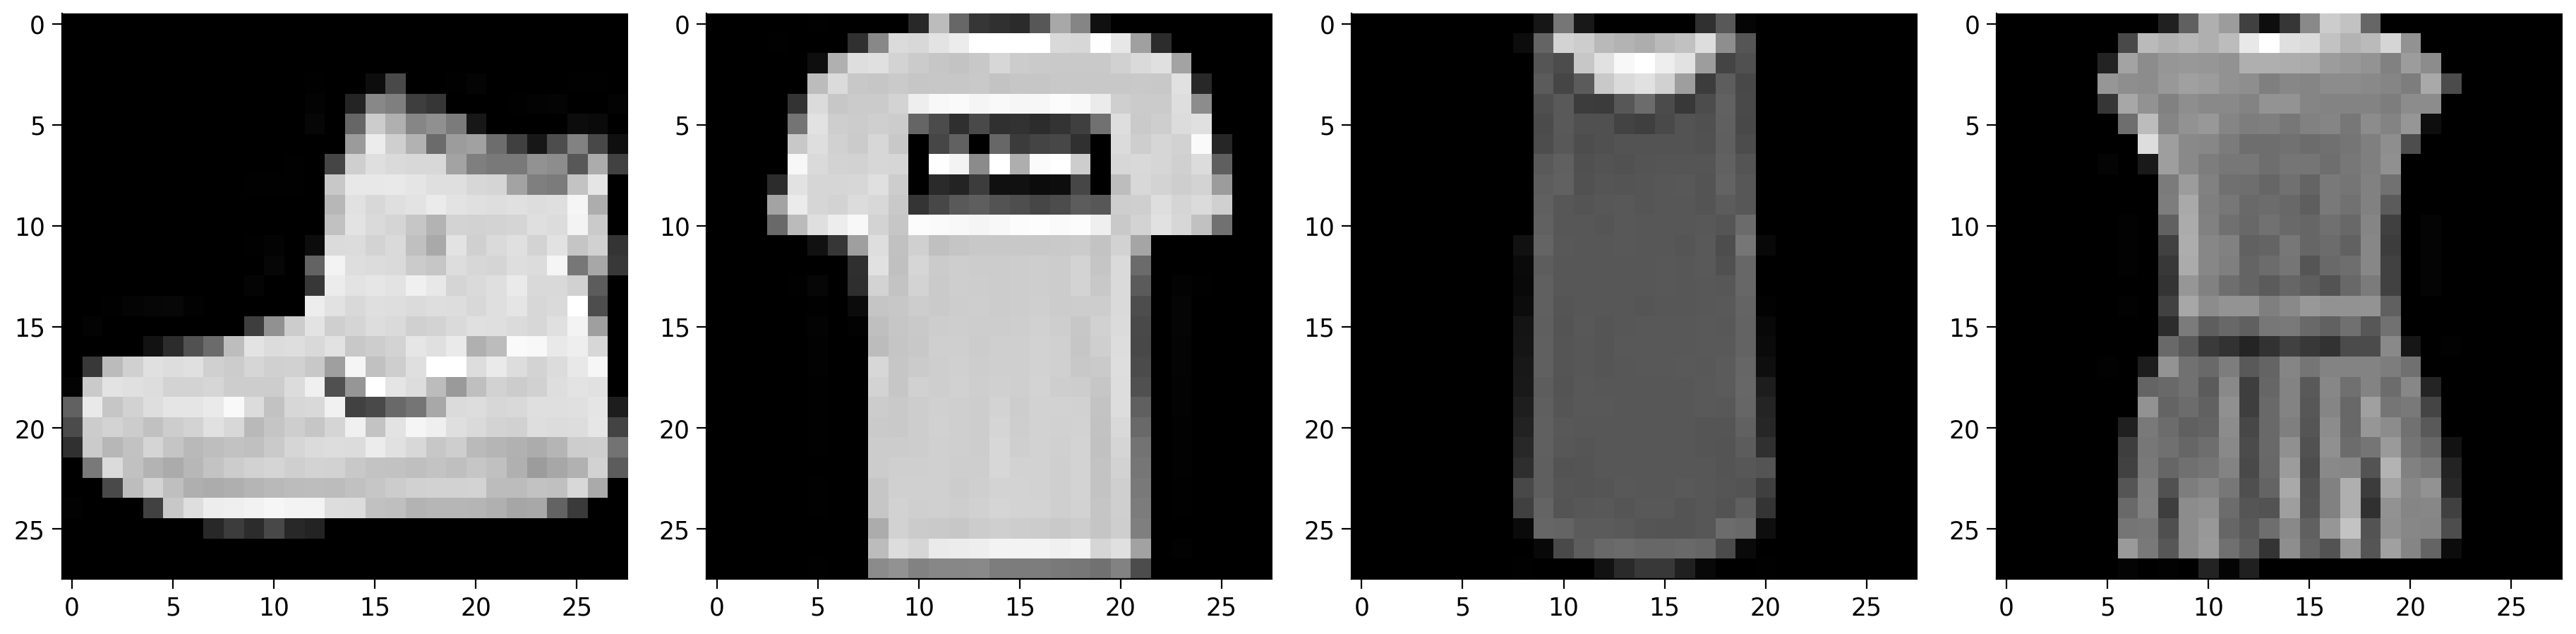

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()